In [ ]:
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
# all the preprocessing logic
def preprocess_raw_data(df: pd.DataFrame):
    # transform categorical columns to pandas categorical data type
    for cname in df.select_dtypes("object").columns:
        df[cname] = df[cname].astype("category")
    nominal_names = ['State', 'Sex', 'PhysicalActivities','HadAngina','HadStroke','HadAsthma','HadSkinCancer', 'HadCOPD'
                 ,'HadDepressiveDisorder','HadKidneyDisease','HadArthritis','HadDiabetes','DeafOrHardOfHearing','BlindOrVisionDifficulty'
                 ,'DifficultyConcentrating','DifficultyWalking','DifficultyDressingBathing','DifficultyErrands','ChestScan','RaceEthnicityCategory'
                 ,'AlcoholDrinkers', 'HIVTesting','FluVaxLast12','PneumoVaxEver','TetanusLast10Tdap','HighRiskLastYear','CovidPos']
    ordinal_names = ['GeneralHealth', 'LastCheckupTime', 'RemovedTeeth','SmokerStatus','ECigaretteUsage','AgeCategory']
    assert len(nominal_names) + len(ordinal_names) + 1 == len(df.select_dtypes("category").columns)
    noms = pd.get_dummies(df[nominal_names], dtype=pd.UInt8Dtype())
    y = pd.get_dummies(df[["HadHeartAttack"]], dtype=pd.UInt8Dtype(), drop_first=True)
    df = df.drop(nominal_names + ["HadHeartAttack"], axis=1).join(noms)
    general_health_mapper = {'Excellent': 4, 'Good': 3, 'Fair': 2, 'Poor': 1, 'Very good': 0}
    lastcheckup_mapper = {'Within past year (anytime less than 12 months ago)': 3, 'Within past 2 years (1 year but less than 2 years ago)': 2
                        ,'Within past 5 years (2 years but less than 5 years ago)': 1, '5 or more years ago': 0}
    removed_teeth_mapper = {'None of them': 3, '1 to 5': 2, '6 or more, but not all': 1, 'All': 0}
    somker_status_mapper = {'Never smoked': 3, 'Former smoker': 2, 'Current smoker - now smokes some days': 1
                            , 'Current smoker - now smokes every day': 0}
    ecigar_mapper = {'Never used e-cigarettes in my entire life': 3, 'Not at all (right now)': 2, 'Use them some days': 1,
                    'Use them every day': 0}
    age_mapper = {
        "Age 18 to 24": 12,
        "Age 25 to 29": 11,
        "Age 30 to 34": 10,
        "Age 35 to 39": 9,
        "Age 40 to 44": 8,
        "Age 45 to 49": 7,
        "Age 50 to 54": 6,
        "Age 55 to 59": 5,
        "Age 60 to 64": 4,
        "Age 65 to 69": 3,
        "Age 70 to 74": 2,
        "Age 75 to 79": 1,
        "Age 80 or older": 0
    }
    mappers = [general_health_mapper, lastcheckup_mapper, removed_teeth_mapper, somker_status_mapper, ecigar_mapper, age_mapper]
    for i, cname in enumerate(ordinal_names):
        df[cname] = df[cname].replace(mappers[i])
    return df, y

In [ ]:
data, Y = preprocess_raw_data(pd.read_csv("./data/heart_2022_no_nans.csv", index_col=False))

In [ ]:
data.head()

In [ ]:
Y.head()

In [ ]:
data = data.select_dtypes(exclude=["object", "string"])

In [ ]:
data.shape

In [ ]:
# remove features that have a low variance
from sklearn.feature_selection import VarianceThreshold
# if a feature column is the same 98% of the time, we'll remove it
thresh = 0.98
sel = VarianceThreshold(threshold=(thresh * (1 - thresh)))
sel.set_output(transform='pandas')
sel.fit(data)
selected_data = sel.transform(data)

In [ ]:
selected_data

In [ ]:
# from sklearn.model_selection import train_test_split


# X_train, X_test, y_train, y_test = train_test_split(selected_data, Y, train_size=0.8, shuffle=True, random_state=42)

In [ ]:
# print("X_train shape: ", X_train.shape)
# print("X_test shape: ", X_test.shape)

In [135]:
import matplotlib.pyplot as plt
def plot_importance(model, traindf):
    feat_imp = pd.Series(model.feature_importances_, index=traindf.columns)
    feat_imp.nlargest(15).plot(kind='barh', xlabel="feature importance").invert_yaxis()

#### Assessment of some of the models and their feature importance graph

[0.91972524 0.91346584 0.92447768 0.91874644 0.92557516 0.92183562
 0.92175433 0.89704089 0.92187627 0.92183562] 0.918633309523314


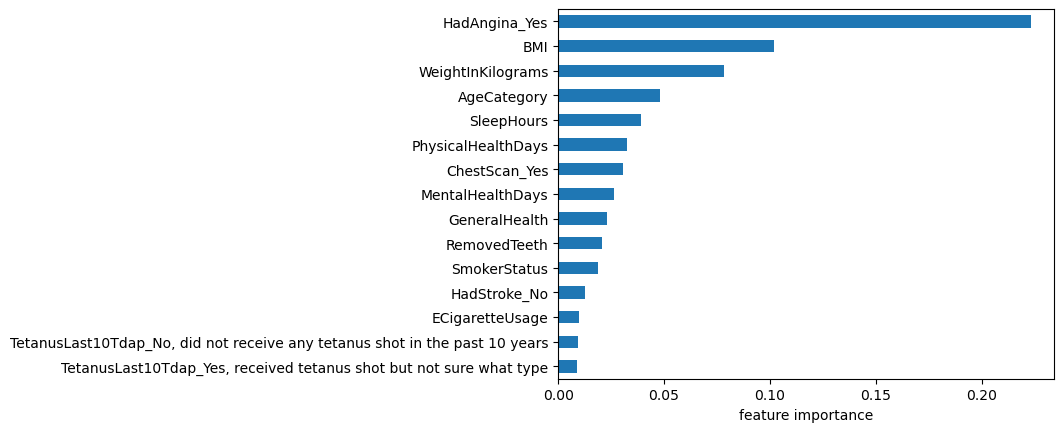

In [140]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dc = DecisionTreeClassifier(criterion='entropy')
dc.fit(selected_data, Y)
plot_importance(dc, selected_data)
dc_cv = cross_val_score(dc, selected_data, Y, cv=10)
print(dc_cv, dc_cv.mean())

[0.9486648  0.94663252 0.94898789 0.94687424 0.948744   0.94943501
 0.94976018 0.94569547 0.94784977 0.94732136] 0.9479965234642652


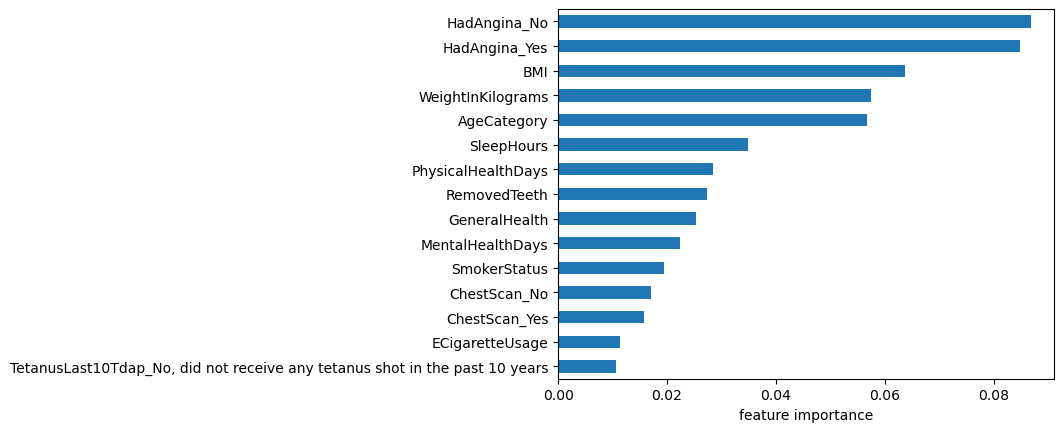

In [141]:
from sklearn.ensemble import RandomForestClassifier
svc = RandomForestClassifier(criterion='entropy', n_estimators=100, n_jobs=8)
svc.fit(selected_data, Y)
plot_importance(svc, selected_data)
svc_cv = cross_val_score(svc, selected_data, Y, cv=10)
print(svc_cv, svc_cv.mean())

[0.94846157 0.94695769 0.94793106 0.94658971 0.94955695 0.94695553
 0.94825624 0.93728152 0.94508577 0.94687424] 0.9463950271552808


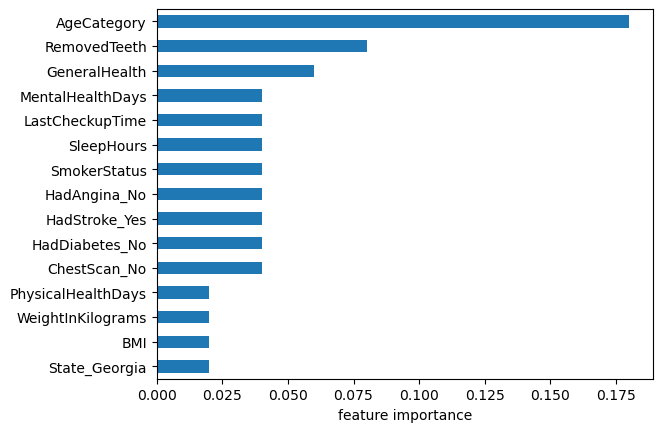

In [142]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(selected_data, Y)
plot_importance(ada, selected_data)
ada_cv = cross_val_score(ada, selected_data, Y, cv=10)
print(ada_cv, ada_cv.mean())

[0.95029061 0.94744543 0.94959759 0.94671165 0.94971953 0.94996342
 0.95000406 0.93626534 0.94756524 0.94862206] 0.9476184955042337


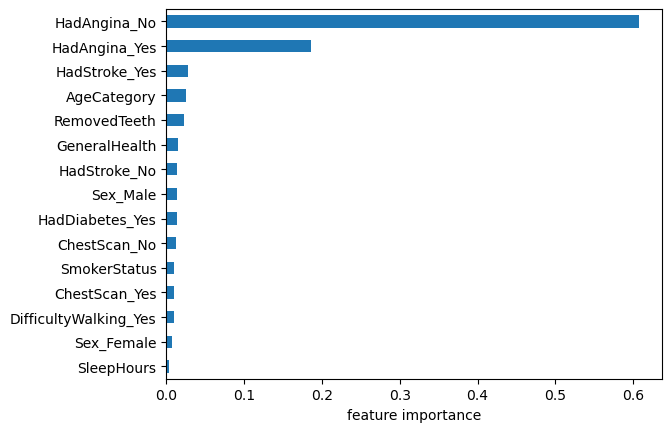

In [143]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(selected_data, Y)
plot_importance(gb, selected_data)
gb_cv = cross_val_score(gb, selected_data, Y, cv=10)
print(gb_cv, gb_cv.mean())